In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.metrics import adjusted_rand_score
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

# Batch effect (invasive cancer patches)

In [2]:
with open("../../config/config_notebooks_HER2.json", "r") as config_file:
    config = json.load(config_file)

path_to_invasive_clustering_full = os.path.join(config['retrained_benchmark_folder2'], "invasive_cancer_clustering", "kmeans")
labels_HER2 = pd.read_csv(os.path.join(path_to_invasive_clustering_full, "uni/invasive_labels_7_clusters_umap_min_dist_0.001_n_neighbors_10.csv"), index_col=0)
labels_HER2["patient_id"] = labels_HER2.index.str.split("_").str[0]

In [3]:
# Create contingency tables
contingency_HER2 = pd.crosstab(labels_HER2['predicted_label'], labels_HER2['patient_id'])

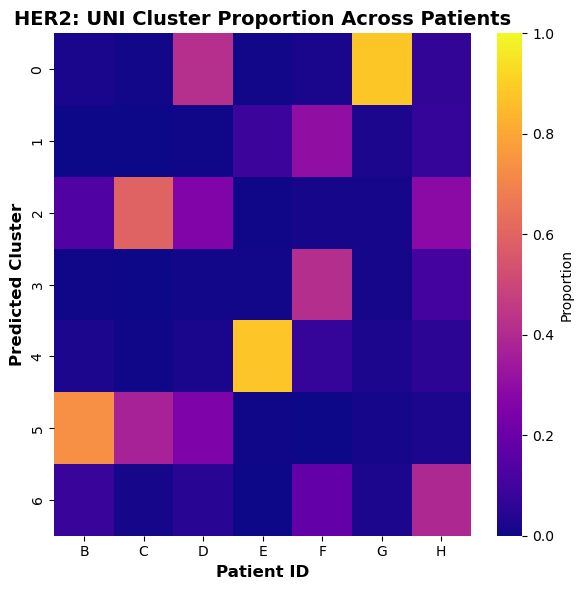

In [4]:
# HER2 Heatmap
# Normalize by patient (columns sum to 1)
contingency_HER2_norm = contingency_HER2.div(contingency_HER2.sum(axis=0), axis=1)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(contingency_HER2_norm, cmap='plasma', annot=False, fmt='.2f', cbar_kws={'label': 'Proportion'}, ax=ax, vmin=0, vmax=1)
ax.set_xlabel('Patient ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Cluster', fontsize=12, fontweight='bold')
ax.set_title('HER2: UNI Cluster Proportion Across Patients', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
path_to_invasive_clustering_base = os.path.join(config['base_benchmark_folder'], "invasive_cancer_clustering", "kmeans")
labels_uni = pd.read_csv(os.path.join(path_to_invasive_clustering_full, "uni/invasive_labels_7_clusters_umap_min_dist_0.001_n_neighbors_10.csv"), index_col=0)
labels_uni2 = pd.read_csv(os.path.join(path_to_invasive_clustering_base, "uni2/invasive_labels_6_clusters_umap_min_dist_0.001_n_neighbors_10.csv"), index_col=0)
labels_prov = pd.read_csv(os.path.join(path_to_invasive_clustering_base, "provgigapath/invasive_labels_8_clusters_umap_min_dist_0.001_n_neighbors_350.csv"), index_col=0)
labels_uni2["patient_id"] = labels_uni2.index.str.split("_").str[0]
labels_prov["patient_id"] = labels_prov.index.str.split("_").str[0]
labels_uni["patient_id"] = labels_uni.index.str.split("_").str[0]


UNI2 - Chi-square test of independence:
  Chi-square statistic: 156899.6845
  p-value: < 1e-300 (extremely significant)
  Degrees of freedom: 30
  Significant: Yes (highly significant)


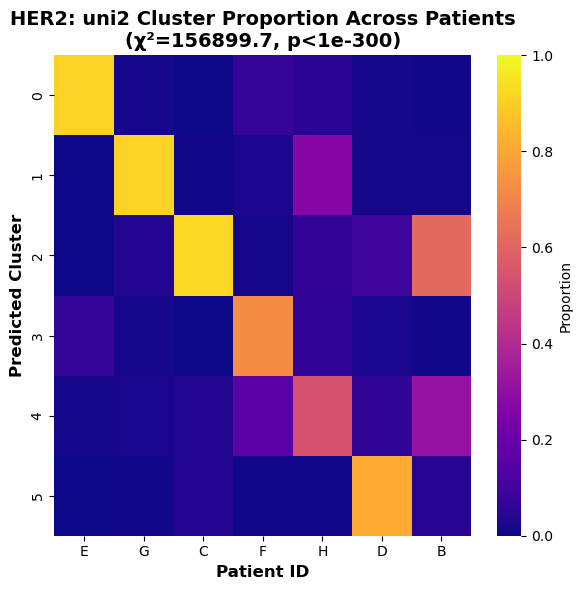


PROVGIGAPATH - Chi-square test of independence:
  Chi-square statistic: 103921.3829
  p-value: < 1e-300 (extremely significant)
  Degrees of freedom: 42
  Significant: Yes (highly significant)


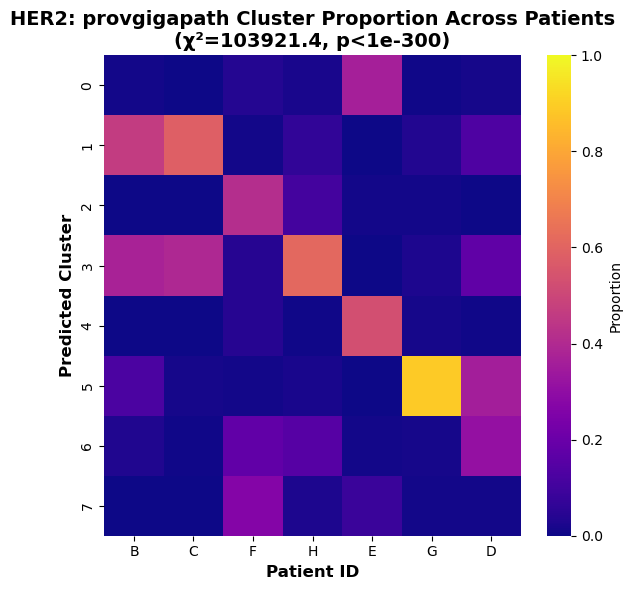


UNI - Chi-square test of independence:
  Chi-square statistic: 115649.4956
  p-value: < 1e-300 (extremely significant)
  Degrees of freedom: 36
  Significant: Yes (highly significant)


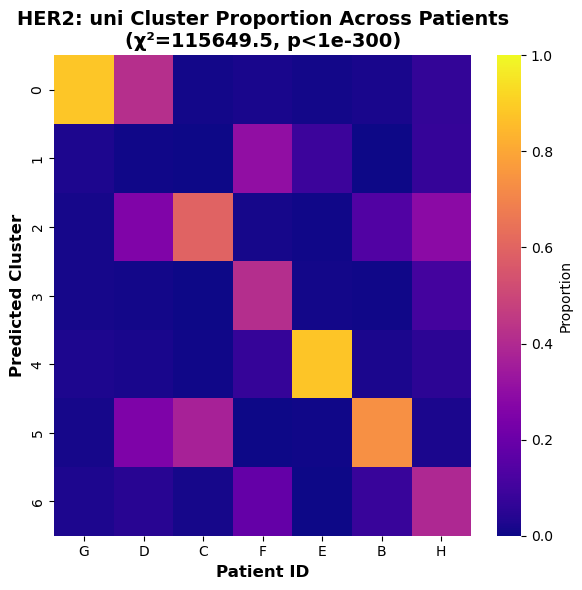

In [6]:
from scipy.stats import chi2_contingency
results_base = {}
for labels, name in zip([labels_uni2, labels_prov, labels_uni], ["uni2", "provgigapath", "uni"]):
    contingency_HER2 = pd.crosstab(labels['predicted_label'], labels['patient_id'])
    contingency_HER2_norm = contingency_HER2.div(contingency_HER2.sum(axis=0), axis=1)
    
    # Perform chi-square test for independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_HER2)
    
    # Handle very small p-values
    if p_value == 0.0:
        p_str = "< 1e-300 (extremely significant)"
        p_title = "p<1e-300"
    else:
        p_str = f"{p_value:.4e}"
        p_title = f"p={p_value:.2e}"
    
    print(f"\n{name.upper()} - Chi-square test of independence:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  p-value: {p_str}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Significant: Yes (highly significant)" if p_value < 0.001 else f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Sort columns for uni model
    if name == "uni":
        contingency_HER2_norm = contingency_HER2_norm[["G", "D", "C", "F", "E", "B", "H"]]
    if name == "provgigapath":
        contingency_HER2_norm = contingency_HER2_norm[["B", "C", "F", "H", "E", "G", "D"]]
    if name == "uni2":
        contingency_HER2_norm = contingency_HER2_norm[["E", "G", "C", "F", "H", "D", "B"]]
        
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(contingency_HER2_norm, cmap='plasma', annot=False, fmt='.2f', cbar_kws={'label': 'Proportion'}, ax=ax, vmin=0, vmax=1)
    ax.set_xlabel('Patient ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Cluster', fontsize=12, fontweight='bold')
    ax.set_title(f'HER2: {name} Cluster Proportion Across Patients\n(χ²={chi2:.1f}, {p_title})', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    results_base[name] = {"chi2": chi2, "p_value": p_value, "dof": dof, "ari": 1- adjusted_rand_score(labels['patient_id'], labels['predicted_label'])}

Processing model: uni
Processing model: uni_explora_kde_4096_prototypes
Processing model: uni_explora_kde_16384_prototypes
Processing model: uni_explora_kde_65536_prototypes
Processing model: uni_explora_koleo_4096_prototypes
Processing model: uni_explora_koleo_16384_prototypes
Processing model: uni_explora_koleo_65536_prototypes
Processing model: uni
Processing model: uni_full_kde_4096_prototypes
Processing model: uni_full_kde_16384_prototypes
Processing model: uni_full_kde_65536_prototypes
Processing model: uni_full_koleo_4096_prototypes
Processing model: uni_full_koleo_16384_prototypes
Processing model: uni_full_koleo_65536_prototypes


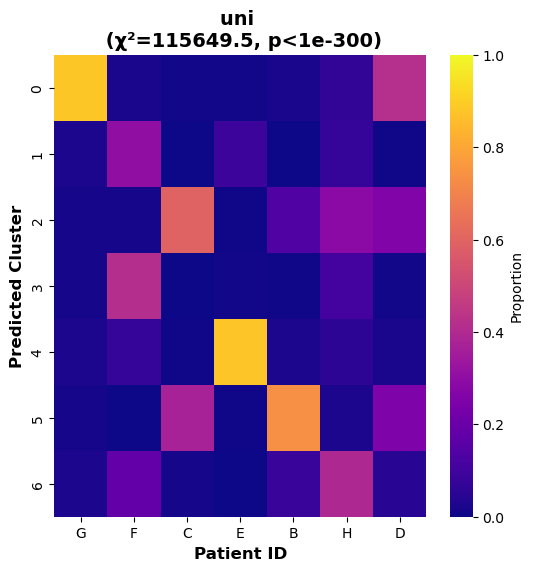

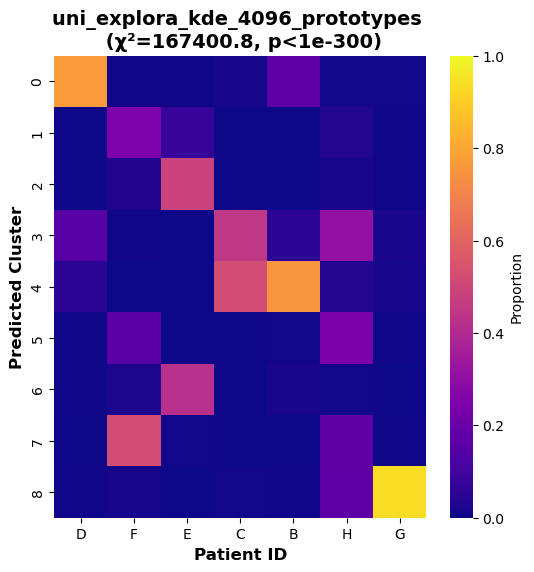

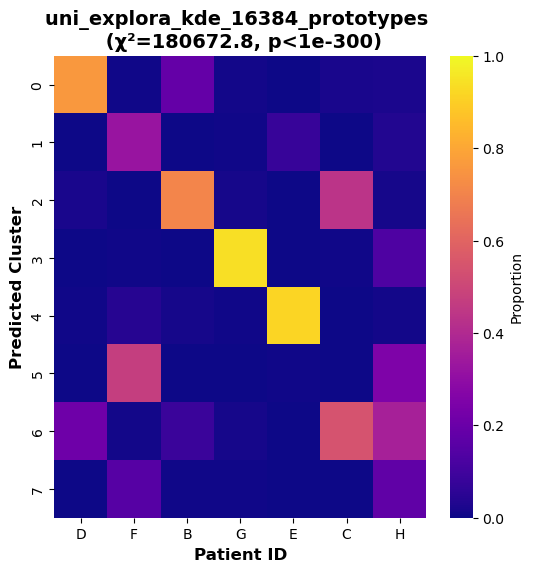

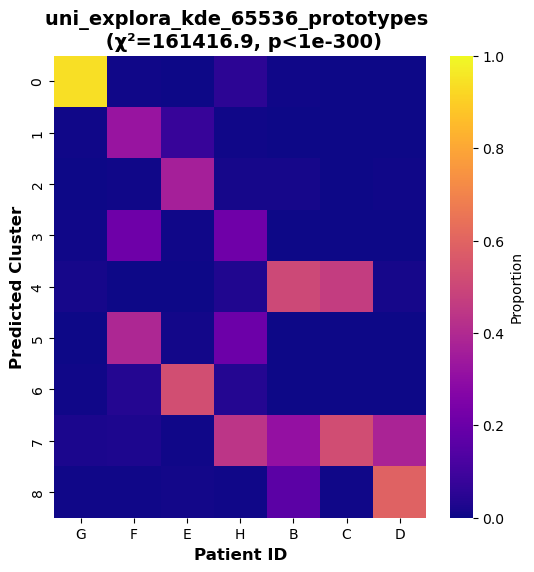

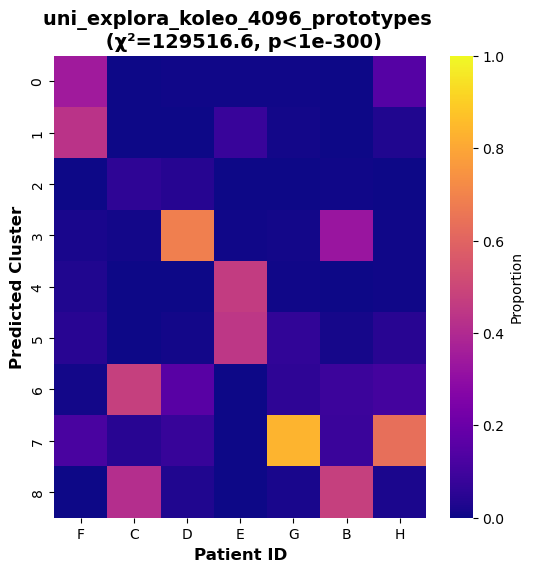

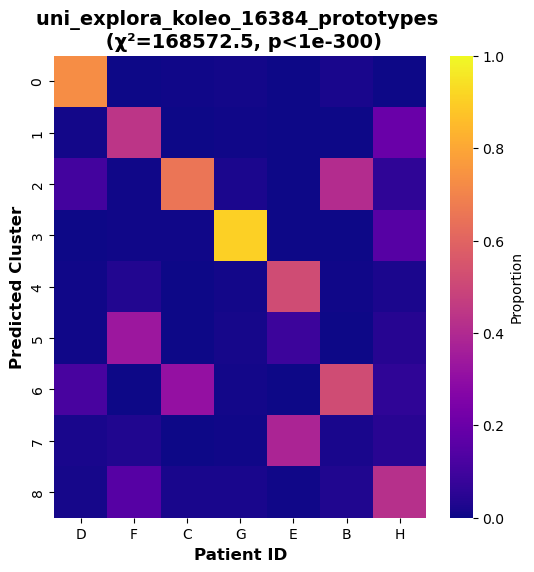

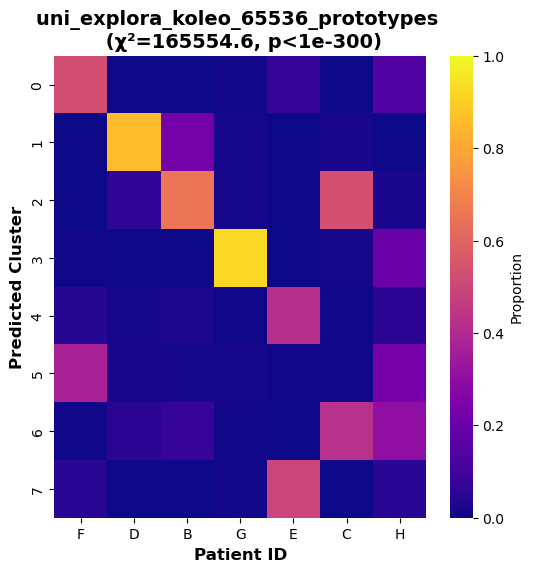

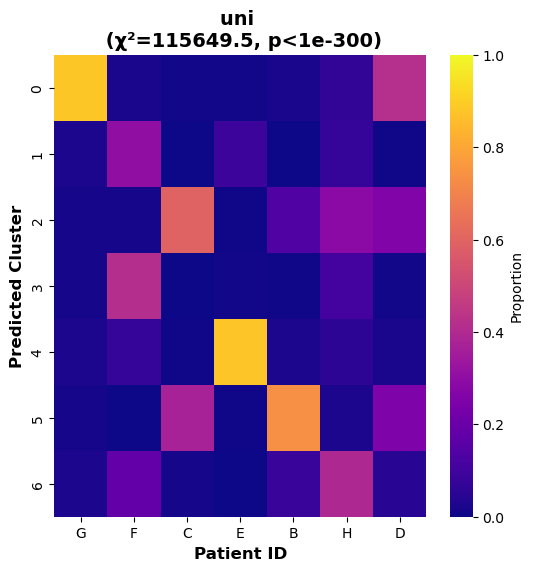

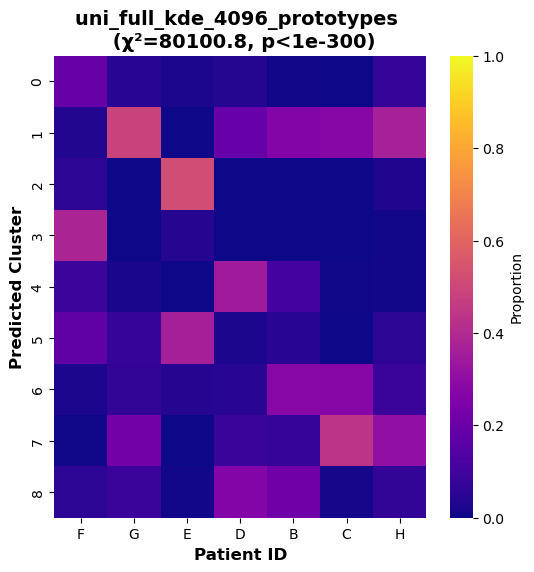

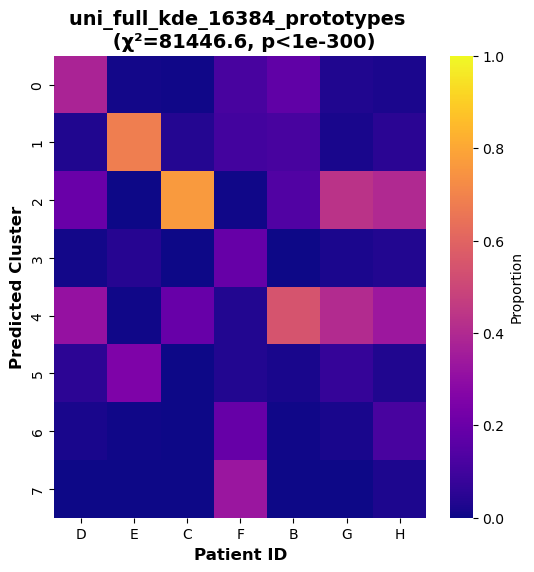

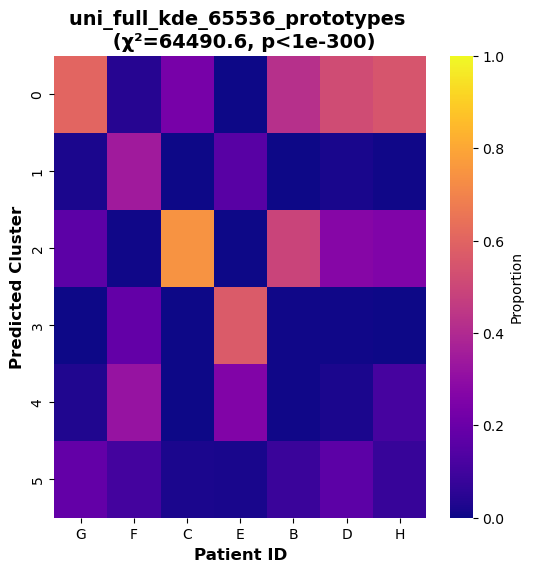

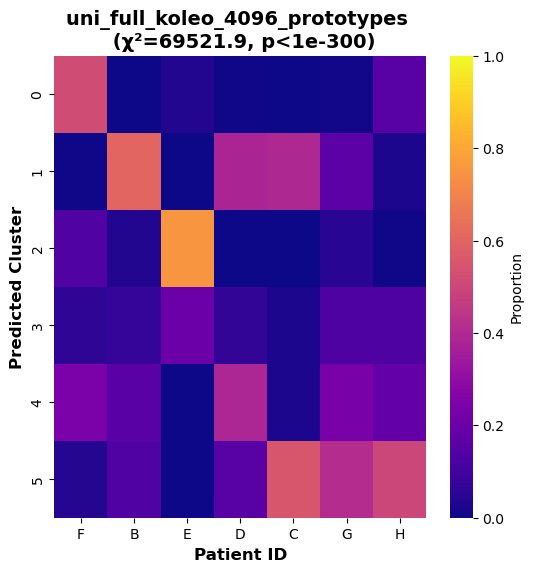

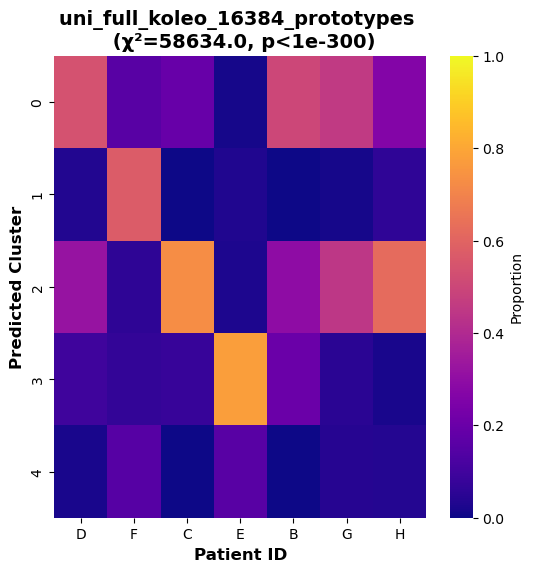

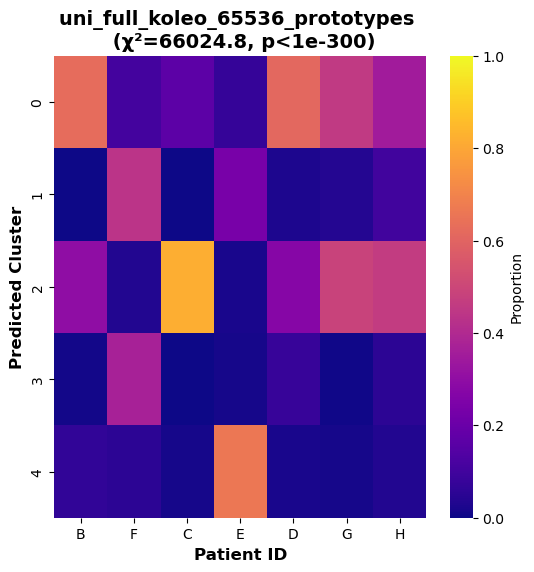

In [7]:
results = {}
aris_invasive = {}
for names, benchmark_path in zip(
    [config['retrained_model_list1'], config['retrained_model_list2']], 
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):
    
  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "opti_clusters.csv"), index_col=0) # from notebook 5
  
  for name in names:
    print(f"Processing model: {name}")
    n_clusters = opti_clusters.loc[name, 'n_clusters']

    filename = glob.glob(os.path.join(
        path_to_invasive_cancer_clustering_results, name, f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]

    df = pd.read_csv(filename, index_col=0)
    df['patient_id'] = df.index.str.split('_').str[0]
    
    contingency = pd.crosstab(df['predicted_label'], df['patient_id'])
    contingency_norm = contingency.div(contingency.sum(axis=0), axis=1)
    batch_mitigation_invasive = 1-adjusted_rand_score(df['patient_id'], df['predicted_label'])
    
    # Perform chi-square test for independence
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    results[name] = {"chi2": chi2, "p_value": p_value, "dof": dof, "ari": batch_mitigation_invasive}
    
    # Sort columns to maximize diagonal values
    # For each row, find the column with max value, then reorder
    row_max_cols = contingency_norm.idxmax(axis=1).values
    # Create column order based on which column is max for each row
    col_order = []
    used_cols = set()
    for row_idx in contingency_norm.index:
        max_col = contingency_norm.loc[row_idx].idxmax()
        if max_col not in used_cols:
            col_order.append(max_col)
            used_cols.add(max_col)
    # Add any remaining columns not yet used
    for col in contingency_norm.columns:
        if col not in used_cols:
            col_order.append(col)
    contingency_norm = contingency_norm[col_order]
    
    p_title = f"p={p_value:.2e}" if p_value != 0.0 else "p<1e-300"
    
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(contingency_norm, cmap='plasma', annot=False, fmt='.2f', cbar_kws={'label': 'Proportion'}, ax=ax, vmin=0, vmax=1)
    ax.set_xlabel('Patient ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Cluster', fontsize=12, fontweight='bold')
    ax.set_title(f'{name} \n (χ²={chi2:.1f}, {p_title})', fontsize=14, fontweight='bold')

In [8]:
retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

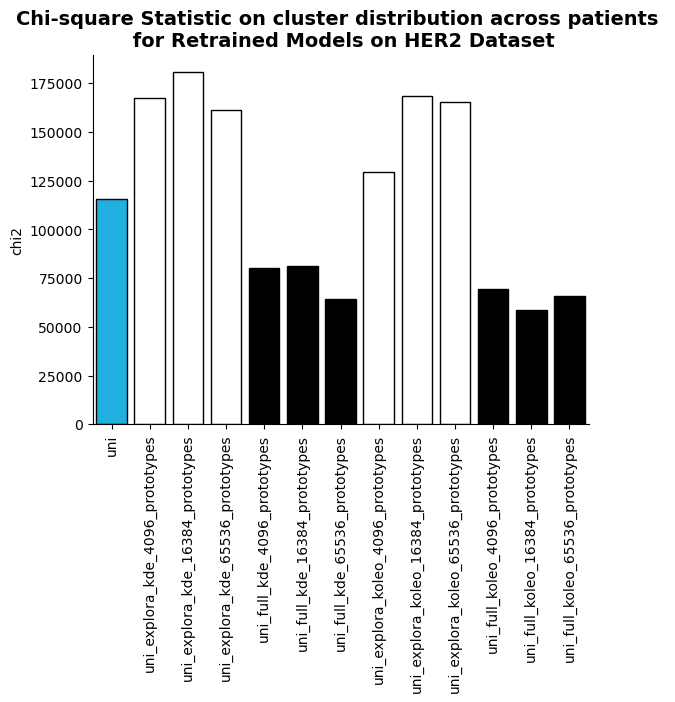

In [9]:
df_plot = pd.DataFrame(results)

sns.barplot(df_plot.loc["chi2"][sorted_retrained_models], palette=palette, edgecolor='black')
plt.xticks(rotation=90)
sns.despine()
plt.title(f"Chi-square Statistic on cluster distribution across patients \n for Retrained Models on HER2 Dataset", fontsize=14, fontweight='bold')
plt.show()

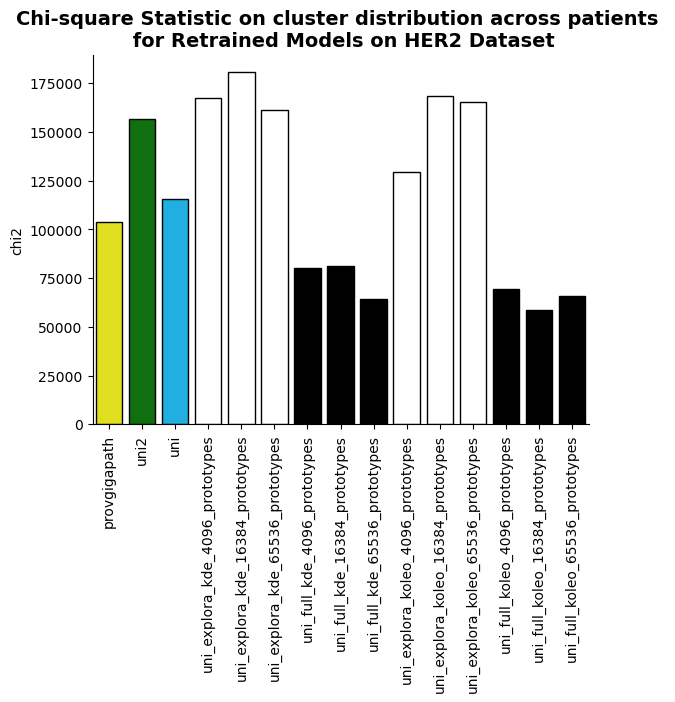

In [10]:
results_combined = {**results_base, **results}
df_plot = pd.DataFrame(results_combined)

sns.barplot(df_plot.loc["chi2"][["provgigapath", "uni2"] + sorted_retrained_models], palette=["yellow", "green"] + palette, edgecolor='black')
plt.xticks(rotation=90)
sns.despine()
plt.title(f"Chi-square Statistic on cluster distribution across patients \n for Retrained Models on HER2 Dataset", fontsize=14, fontweight='bold')
plt.show()

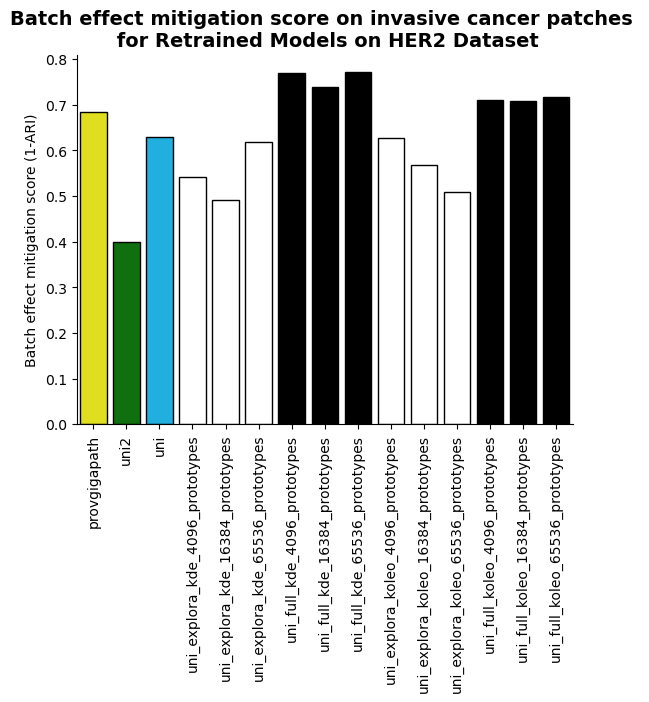

In [11]:
sns.barplot(df_plot.loc["ari"][["provgigapath", "uni2"] + sorted_retrained_models], palette=["yellow", "green"] + palette, edgecolor='black')
plt.xticks(rotation=90)
plt.ylabel(f"Batch effect mitigation score (1-ARI)")
sns.despine()
plt.title(f"Batch effect mitigation score on invasive cancer patches \n for Retrained Models on HER2 Dataset", fontsize=14, fontweight='bold')
plt.show()